# <font color=darkcyan> Supervised learning to analyse microbiota data</font>

Before we dive in the study, we import some standard packages for data analysis.

In [1]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the usual packages

# NumPy is a common library for linear algebra
# See the doc here: https://numpy.org/
import numpy as np

# MatplotLib and its module PyPlot are common visualization tools
# See the doc here: https://matplotlib.org/
import matplotlib.pyplot as plt

# Pandas is a library to manipulate multi-type data as DataFrame objects, which provides numereous tools for data engineering
# See the doc here: https://pandas.pydata.org/
import pandas as pd

## <font color=darkred> Gut microbiota data vizualisations</font>

The gut microbiota is defined by all the bacteria, viruses and parasites that lives in the gastrointestinal tract. In that study, we focus on the bacteria specifically which composes the vast majority of the microbiome. (https://en.wikipedia.org/wiki/Microbiota)

The bacteria can be arranged in hierarchical groups, which originate from their genomic proximity. This hierarchical architecture is called a **taxonomy**, and the different groups are called **taxa**, which are organized in layers of increasing precision. *(see gut microbiota taxonomy example below for a type of arion ater)*

``Illustration of a phylogenetic tree showing the diversity of the A. ater gut microbiome down to genus level. Visualised using GraPhlAn.``

![image.png](https://www.frontiersin.org/files/Articles/290624/fmicb-08-02181-HTML/image_m/fmicb-08-02181-g001.jpg)

_Ryan Joynson et al. “Metagenomic Analysis of the Gut Microbiome of the Common Black Slug Arion ater in Search of
Novel Lignocellulose Degrading Enzymes”. In: Frontiers in Microbiology 8 (2017). issn: 1664-302X. doi:
10.3389/fmicb.2017.02181. url: https://www.frontiersin.org/articles/10.3389/fmicb.2017.02181_

Then, looking at one specific individual, we can determine the quantity of a given bacteria in their microbiota. This enables us to annotate the global taxonomy with the **abundance of each bacteria**, creating a **taxa-abundance sample** that describes the individual's microbiome composition. *(see taxa-abundance sample below)*

``A. The image is filled with species abundances (left) or presences (right). B. For a single sample, the phylogenetic tree is constructed, populated with species abundances, and rearranged into a matrix.``
![image-2.png](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs43705-022-00182-9/MediaObjects/43705_2022_182_Fig1_HTML.png?as=webp)

_Ricardo Hernández Medina et al. “Machine learning and deep learning applications in microbiome research”. In: ISME
Communications 2.1 (2022), p. 98_

In the following section, we will provide vizualisations of the taxonomy being studied, as well as showing a typical taxa-abundance sample.


**Our dataset is composed of 35 individuals that were followed after a surgery relating to Crohn's disease, among which 13 have recovered or partially recovered from the disease. Our goal will then be to predict potential future patient's complications based on these entries**.

### <font color=blue> Data loader utils for taxa-abundance data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# We define an object "Node" to build the abundance trees
class Node:

    # Constructor method, initializes the node by a recursive parent/children relationship
    # The value accounts for the abundance
    # The index and depth are indicating the position of the node in different annotations (matrix, vector, tree)
    def __init__(self, parent, children, value=1, index=0, depth=0, name="Unknown"):
        self.parent = parent

        self.children = children
        if self.children is None:
            self.children = []

        self.index = index
        self.depth = depth
        self.graph_position = [0, depth]
        self.value = value
        self.name = name

    def hasParent(self):
        return self.parent is not None

    def addChild(self, child):
        self.children.append(child)

    def hasChildren(self):
        return self.countChildren() > 0

    def countChildren(self):
        return len(self.children)

    def countNonZeroChilren(self):
        count = 0
        for child in self.children:
            count += (child.value > 0) * 1
        return count

# We create a "Tree" object which is a composition of nodes, built from an adjacency matrix
class Tree:

    def __init__(self, adjacent_matrix):
        self.adjacent_matrix = np.array(adjacent_matrix)
        self.root = Node(None, None)
        self.depth = 0

        self.nodes = np.array([Node(None, None, index=i) for i in range(len(self.adjacent_matrix))])
        self.nodes[0] = self.root

        current_index = 0
        while current_index < len(self.adjacent_matrix):
            # Fetch the current node
            current_node = self.nodes[current_index]
            # Look for the nodes that are connected to the current node, which are necessarily his children
            children_nodes_index = np.where(self.adjacent_matrix[current_index] != 0)[0]
            # For all child in the found children, associate their parent to the current node and append the child
            for child in self.nodes[children_nodes_index]:
                child.parent = current_node
                child.depth = current_node.depth + 1
                self.depth = max(child.depth, self.depth)
                current_node.addChild(child)
            current_index += 1

    def getMaxDepth(self):
        max_depth = 0
        for node in self.nodes:
            if node.depth > max_depth:
                max_depth = node.depth
        return max_depth

    def getLeaves(self):
        return self.getNodesAtDepth(self.depth)

    def getNodesAtDepth(self, depth):
        nodes = []
        for node in self.nodes:
            if node.depth == depth:
                nodes.append(node)
        return nodes

    def plot(self, space=10e10, title=None, fig=None, axs=None, cmap=plt.cm.get_cmap('Blues'), legend=True, threshold_abundance=10e-2):
        if fig is None or axs is None:
            fig, axs = plt.subplots(figsize=(15,7))
        axs.set_yticks([])
        axs.set_xticks([])
        axs.axis('off')
        if title is None:
            fig.suptitle("Tree representation")
        else:
            fig.suptitle(title)

        if legend:
            # Create a ScalarMappable object with the colormap 'Blues'
            sm = plt.cm.ScalarMappable(cmap=cmap)

            # Set the limits of the colorbar to match your plot data
            sm.set_clim(0, 1)

            # Add a colorbar to the plot
            cbar = fig.colorbar(sm)
            cbar.set_label('Abundance')

        n_nodes_per_layer = []
        depth = 1
        while len(self.getNodesAtDepth(depth)) > 0:
            n_nodes_per_layer.append(self.getNodesAtDepth(depth))
            depth += 1

        graph_grid = {}
        index = 1
        for depth, nodes in enumerate(n_nodes_per_layer):
            n_nodes = len(nodes)
            j = 0
            pos = np.linspace(
                1 * n_nodes + space,
                -1 * n_nodes - space,
                n_nodes
            )
            while j < n_nodes:
                graph_grid[nodes[j].index] = [pos[j], -depth - 1]
                j += 1
                index += 1

        # Then recursively plot the nodes
        def recursive_plot_nodes(node):
            if node.hasChildren():

                for i, child in enumerate(node.children):
                    if child.value == 0:
                        continue
                    child.graph_position = graph_grid[child.index]
                    axs.plot([child.graph_position[0]],
                             [child.graph_position[1]], color=cmap(child.value-10e-10), marker="o", markersize=12)
                    if child.value > threshold_abundance:
                        axs.text(
                            child.graph_position[0],
                            child.graph_position[1],
                            f'{child.index}',
                            ha='center',
                            va='center',
                            ma='center',
                            color='white',
                            fontsize='small'
                        )

                    recursive_plot_nodes(child)
        def recursive_plot_lines(node):
            if node.hasChildren():

                for i, child in enumerate(node.children):
                    if child.value == 0:
                        continue
                    child.graph_position = graph_grid[child.index]
                    axs.plot([child.graph_position[0], node.graph_position[0]],
                             [child.graph_position[1], node.graph_position[1]],
                             color=cmap(child.value-10e-10), linestyle="-", marker="")

                    recursive_plot_lines(child)

        recursive_plot_lines(self.root)
        recursive_plot_nodes(self.root)

        # Adding the root to the graph
        axs.plot([self.root.graph_position[0]], [self.root.graph_position[1]], color=cmap(1-10e-10), marker="o", markersize=12)
        axs.text(
            self.root.graph_position[0],
            self.root.graph_position[1],
            f'{self.root.index}',
            va='center', ha='center',
            color='white')

# Abundance trees are a subclass of trees for which the value account for the abundance
class AbundanceTree(Tree):

    def __init__(self, adjancent_matrix, abundance_values):
        super().__init__(adjancent_matrix)
        self.abundance_values = abundance_values
        for node in self.nodes:
            value = (node.index == 0) * 1
            if node.index in abundance_values:
                value = abundance_values[node.index]
            node.value = value

# Getter for the raw dataset we're using, the precision accounts for the depth in the tree we're diving at
def get_NIPICOL(precision, normalized=True):
    if normalized:
        df = pd.read_csv(
            "https://raw.githubusercontent.com/AlexandreChaussard/Stage-Microbiote/master/Microbiota-Generative-Models/src/data/nipicol_asv.txt",
            sep="	"
            )
    else:
        df = pd.read_csv(
            "https://raw.githubusercontent.com/AlexandreChaussard/Stage-Microbiote/master/Expectation-Maximization/src/data/nipicol_asv_count.txt",
            sep="	"
            )

    precisions = ['d', 'p', 'c', 'o', 'f', 'g', 's']
    if precision >= len(precisions) and precision >= 0:
        print(f"Precision must be between 0 and {len(precisions) - 1}.")
        return None

    rdf = df[df['ASV_ID'].str.contains(f'{precisions[precision]}__')]
    if precision < len(precisions) - 1:
        rdf['ASV_ID'] = rdf['ASV_ID'].str.split(f'{precisions[precision + 1]}__', n=1, expand=True)[0]

    def remove_last_sep(asv_id):
        i = -1
        while '|' in asv_id and asv_id[i] != '|':
            i -= 1
        return asv_id[:i]

    rdf['ASV_ID'] = rdf['ASV_ID'].apply(remove_last_sep)
    rdf = rdf.groupby(by='ASV_ID').sum()

    return rdf


# Getter for the microbiota dataset we're using, automatically turning the data into their tree graphical representation
# Outputs the global taxonomy and the dictionnary of abundance trees for each individual in the dataset
def microbiota_abundance_trees(precision_max=6, normalize=True):
    # First, we fetch the individuals id
    df = get_NIPICOL(0, normalize)
    individuals = df.columns

    # This maps an index to a bacteria name
    mapping_index = {}
    mapping_names = {}
    # This maps a bacteria to its parent
    mapping_parent = {}
    # For each individual, we store the value of the nodes
    node_abundance = {}
    # Current index being explored while building the tree
    current_index = 0
    # List the current possible parents of the bacteria
    current_parents = []

    # We loop over the precisions, building up the general tree from the root to the leaves
    for precision in range(0, precision_max + 1):
        # We fetch the list of the bacteria at the precision layer
        df = get_NIPICOL(precision, normalize)
        # We create a list of future parents to replace the current ones
        future_parents = []
        for bacteria_name in df.index:
            # We prepare the future prents list by adding the current layer
            future_parents.append(bacteria_name)
            # We register the bacteria in both maps of index and parents
            if bacteria_name not in mapping_index.values():
                mapping_index[bacteria_name] = current_index
                mapping_names[current_index] = bacteria_name
                # We fetch the parent of the node
                for parent in current_parents:
                    if parent in bacteria_name:
                        mapping_parent[current_index] = mapping_index[parent]
                        break
                # We update the index
                current_index += 1

            # We fetch the bacteria index
            bacteria_index = mapping_index[bacteria_name]
            # We store the bacteria abundance for every individual
            node_abundance[bacteria_index] = df.loc[bacteria_name]

        # We update the current parents for the next layer
        current_parents = future_parents

    # We look for the size of the adjacent matrix
    size = len(mapping_index)

    # Using the mapping, we can now build the tree
    adjacent_matrix = np.zeros((size, size))
    # We run through the parents to find the children and build the adjacent matrix row after row
    for parent_index in mapping_parent.values():
        # For each parent, we gather the children indexes to build the adjacent vector of that node
        children_index = []
        for node_index in mapping_parent.keys():
            if mapping_parent[node_index] == parent_index:
                children_index.append(node_index)
        # This is not yet the adjacent row, since it's something like [1, 6, 12] instead of [0, 1, 0, 0, ...] vector
        # But we need to gather these to create the full matrix after that
        adjacent_matrix[parent_index][children_index] = 1

    # Now we can build the global tree architecture
    global_tree = Tree(adjacent_matrix=adjacent_matrix)

    # We apply the name of the bacteria to each node in the tree using the matching dictionnary
    for node in global_tree.nodes:
        node.name = mapping_names[node.index].split("| ")[-1]

    # Then, for each individual, we build a corresponding abundance tree
    abundance_trees = {}
    for i, individual in enumerate(individuals):
        # We roam through each column of the abundance which corresponds to a given individual
        # This is the vector of abundance for a given individual for each bacteria, identified by their index
        abundance_values = {}
        for abundance_index, abundance_values_per_indiv in node_abundance.items():
            abundance_values[abundance_index] = abundance_values_per_indiv[i]

        # Now we can build the abundance tree
        abundance_trees[individual] = AbundanceTree(adjacent_matrix, abundance_values)
        # We apply the name of the bacteria to each node in the tree using the matching dictionnary
        for node in abundance_trees[individual].nodes:
            node.name = mapping_names[node.index].split("| ")[-1]

    return global_tree, abundance_trees

# Get the labelized NIPICOL dataset, with some preprocessing applied to filter the individuals as intended
def get_dataset_NIPICOL():
    df = pd.read_csv(
        "https://raw.githubusercontent.com/AlexandreChaussard/Stage-Microbiote/master/Microbiota-Generative-Models/src/data/mapping_nipicol.txt",
         sep="	"
    )
    df.columns = ['id'] + df.columns[1:].tolist()
    # Drop the individuals that are not tagged as "yes" in the "to_take" column
    # Drop the individuals that are not tagged as "S0" in the "to_take" column
    df = df.drop(index=df[~df['to_take'].str.match('yes')].index)
    df = df.drop(index=df[~df['timepoint'].str.match('S0')].index)
    df.reset_index(inplace=True)
    df = df.drop(columns=['index'])
    return df

# Extract the labels from the NIPICOL dataset
def get_labels_NIPICOL():
    df = get_dataset_NIPICOL()
    # We tag as "1" the patients that have partial or complete remission
    y = df['best_irecist2'].apply(lambda x : (x != 'PR_CR') * 1).astype(np.int32)
    y.index = df.id
    return y

# Extract the features of an abundance tree at a given precision depth
def extract_precision_layer(abundance_tree, precision, return_bacteria_nodes=False):
    nodes = abundance_tree.getNodesAtDepth(precision)
    X = [node.value for node in nodes]
    if return_bacteria_nodes:
        bacteria_dic = {}
        for node in nodes:
            bacteria_dic[node.index] = node

        return X, bacteria_dic
    return X

# Extract the features for all abundance trees provided at the given precision depth
# The bias stands for whether we're adding a column of 1 in the output matrix, to account for a bias in the model
def extract_dataset(abundance_trees, precision, bias=True, return_bacteria_nodes=False):
    y = get_labels_NIPICOL()
    X = pd.DataFrame()
    for id, abundance_tree in abundance_trees.items():
        # If we don't have a label for the individual, we skip it
        if id not in y.index:
            continue

        if return_bacteria_nodes:
            X_i, bacteria_dic = extract_precision_layer(abundance_tree, precision, return_bacteria_nodes)
        else:
            X_i = extract_precision_layer(abundance_tree, precision)
        if bias:
            X_i += [1]
        X[id] = X_i
    X = X.transpose()
    if return_bacteria_nodes:
        return X, y, bacteria_dic
    return X, y

### <font color=blue> Dataset and descriptive statistics

---



In this first section, we load the dataset of our study, which is composed of $n = 35$ microbiota coming from patients affected by Crohn's disease.

In this notebook, we are interested in generic learning methods, which can not take in entry a taxonomic tree, but a vector of float values. Hence, we are going to fix a precision $p$ in the taxonomy, and select the row of abundance $X_i \in \mathbb{R}^{d}$ for the individual $i$, that accounts for the $d$ bacteria group abundance within the taxa-abundance sample at layer $p$, for that specific individual $i$.

We then store the vector $(X_i)_{1 \leq i \leq n}$ in a matrix $X \in \mathbb{R}^{n \times d}$ for which each row is a vector $X_i$, with $d$ bacteria accounted for at the precision layer $p$.

During that study, the individuals health were followed several months after a surgery required for the disease treatment. 22 of them have suffered from complications after a certain period, while the 13 others have recovered or partially recovered from the disease.

We store that label information in the vector $Y \in \mathbb{R}^n$ of labels, for which $Y_i \in \{0, 1\}$ indicates whether the patient $i$ has recovered or partially recovered from the disease ($1$ if recovered or partially, $0$ elsewhere).

In [4]:
# Set the precision level in the taxonomy to explore
p = 3
# Fetch the taxa abundance samples
taxonomy, abundance_samples =  microbiota_abundance_trees(precision_max=p)

In [5]:
# We get the raw dataset labels to vizualize the entries
df = get_dataset_NIPICOL()
df.head()

,id,numpat,Exp,timepoint,to_take,Subject_ID,irecistw12,irecistw12_tp,best_irecist,best_irecist_tp,best_irecist2,best_irecist2_tp,iPFS_progr,ipfs_time,os_time,os_event
0,FRA022001CA,FRA022-001,nipicol,S0,yes,1,SD,S0_SD,SD,S0_SD,SD,S0_SD,0,19.022587,19.055441,0
1,FRA022002BB,FRA022-002,nipicol,S0,yes,2,SD,S0_SD,PR,S0_PR,PR_CR,S0_PR_CR,0,25.494867,25.494867,0
2,FRA022003GA,FRA022-003,nipicol,S0,yes,3,SD,S0_SD,PR,S0_PR,PR_CR,S0_PR_CR,0,25.297741,25.297741,0
3,FRA022004MC,FRA022-004,nipicol,S0,yes,4,SD,S0_SD,SD,S0_SD,SD,S0_SD,1,4.501027,4.501027,1
4,FRA022005KF,FRA022-005,nipicol,S0,yes,5,PR,S0_PR,PR,S0_PR,PR_CR,S0_PR_CR,0,25.626283,25.626283,0


In [6]:
print("Number of individuals:", df['timepoint'].count())

Number of individuals: 35


In [7]:
# From the taxa-abundance data, we get a data matrix "X" of the bacteria abundance at a given precision layer
# in addition to "y" the corresponding labels for each individual.
X, y, bacteria_dic = extract_dataset(abundance_samples, p, bias=False, return_bacteria_nodes=True)

# Bacteria abundance for the first 7 individuals
X.head(7)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
FRA022001CA,0.000000,0.029203,0.000402,0.000000,0.001779,0.470511,0.000000,0.0,0.000000,0.0,...,0.025473,0.000000,0.000430,0.000000,0.0,0.006971,0.0,0.000000,0.000000,0.0
FRA022002BB,0.000000,0.000150,0.000414,0.000000,0.000996,0.568708,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.001673,0.000000,0.0,0.020885,0.0,0.003929,0.000000,0.0
FRA022003GA,0.000235,0.000000,0.000000,0.000000,0.064885,0.254727,0.000000,0.0,0.003112,0.0,...,0.000000,0.000000,0.000147,0.000000,0.0,0.005666,0.0,0.239137,0.000000,0.0
FRA022004MC,0.000000,0.000000,0.000000,0.000000,0.006518,0.312572,0.002073,0.0,0.013261,0.0,...,0.000475,0.006618,0.000649,0.015259,0.0,0.010939,0.0,0.009965,0.000000,0.0
FRA022005KF,0.000000,0.004413,0.000000,0.000501,0.001659,0.299962,0.000000,0.0,0.000000,0.0,...,0.003536,0.138637,0.001001,0.000000,0.0,0.002785,0.0,0.000000,0.000000,0.0
FRA022006TS,0.000000,0.042085,0.000000,0.000000,0.014414,0.195004,0.000000,0.0,0.000672,0.0,...,0.000000,0.000000,0.000299,0.000000,0.0,0.005079,0.0,0.006834,0.005265,0.0
FRA022007LP,0.000000,0.001818,0.000826,0.000000,0.015946,0.210058,0.000000,0.0,0.000000,0.0,...,0.012228,0.000000,0.000413,0.000000,0.0,0.000881,0.0,0.022364,0.000468,0.0


In [8]:
#  Patient recovery for the first 7 individuals
y.head(7)

id
FRA022001CA    1
FRA022002BB    0
FRA022003GA    0
FRA022004MC    1
FRA022005KF    0
FRA022006TS    0
FRA022007LP    0
Name: best_irecist2, dtype: int32

In [9]:
print("Number of patients with with partial or total recovery:", y.sum(), "/", len(y))

Number of patients with with partial or total recovery: 13 / 35


The next part of that study aims at showing some descriptive statistics over our data, with the main question being:  can we vizualise any difference between people that have developped complications post-surgery and the one who have not ?


<AxesSubplot: title={'center': 'Label 1'}>

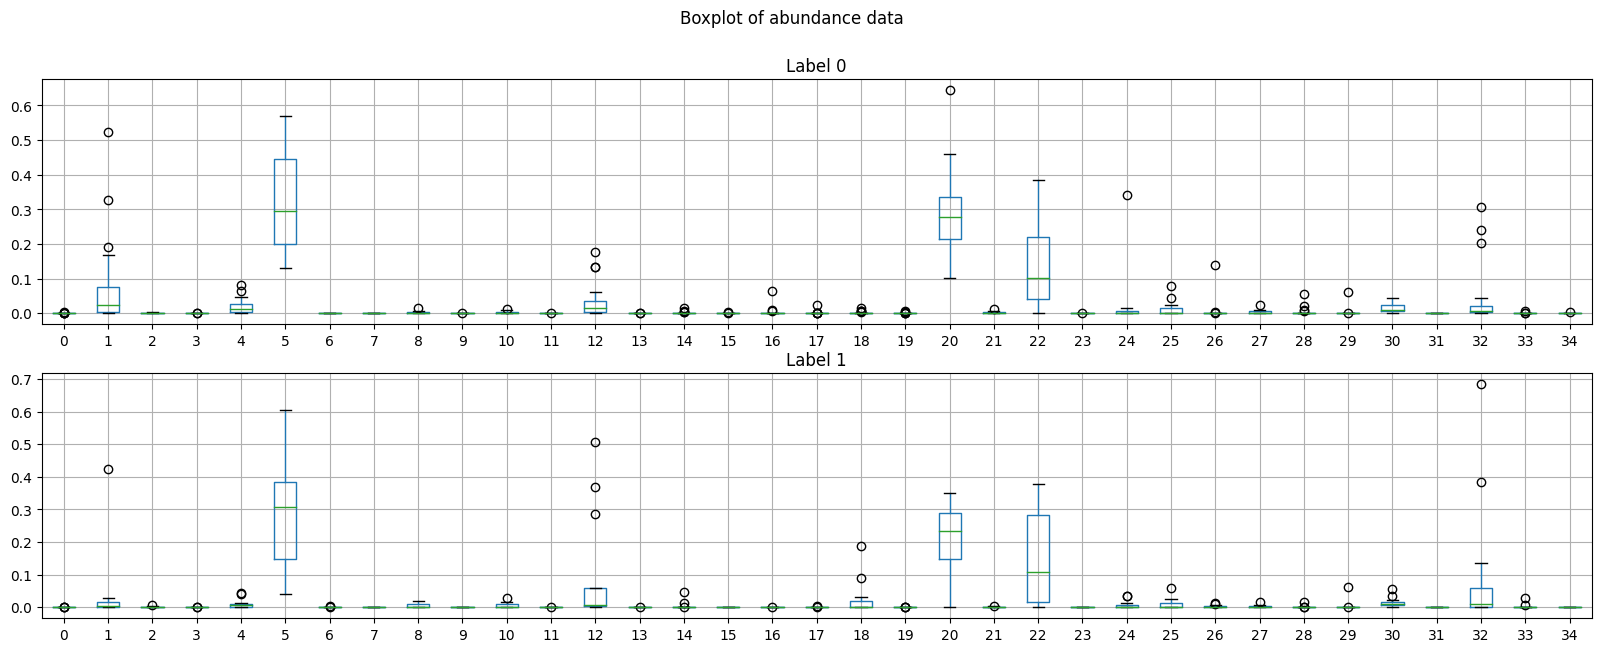

In [10]:
X_label_0 = X[y == 0]
X_label_1 = X[y == 1]

fig, axs = plt.subplots(2, 1, figsize=(20, 7))
fig.suptitle("Boxplot of abundance data")
axs[0].set_title("Label 0")
X_label_0.boxplot(ax=axs[0])
axs[1].set_title("Label 1")
X_label_1.boxplot(ax=axs[1])

Another interesting approach when looking at data is to wonder about the features repartition among the samples.

Especially here, considering that microbiota data are heavily sparse and variable, and that we lack of samples, we might find some bacteria that are present only in 1 microbiota, which could result in selection biases when training.

In [11]:
avg_abundance = X.mean(axis=0)
count_presence = X.apply(lambda x: x != 0, axis=0).sum(axis=0)
bacteria_info = pd.DataFrame()
bacteria_info["name"] = [bacteria_dic[x + min(list(bacteria_dic.keys()))].name for x in X.columns]
bacteria_info["avg_abundance"] = avg_abundance
bacteria_info["count_presence"] = count_presence
bacteria_info = bacteria_info.sort_values(by="count_presence")
bacteria_info

,name,avg_abundance,count_presence
31,o__Cardiobacteriales,0.000000,0
7,o__Campylobacterales,0.000000,0
34,o__Spirochaetales,0.000066,1
23,o__Peptococcales,0.000006,1
9,o__Acholeplasmatales,0.000048,1
15,o__Clostridia,0.000059,2
11,o__Izemoplasmatales,0.000029,2
13,o__Staphylococcales,0.000014,3
29,o__Aeromonadales,0.003471,4
3,o__Micrococcales,0.000056,4


In [12]:
bacteria_info[bacteria_info.count_presence <= 1]

,name,avg_abundance,count_presence
31,o__Cardiobacteriales,0.000000,0
7,o__Campylobacterales,0.000000,0
34,o__Spirochaetales,0.000066,1
23,o__Peptococcales,0.000006,1
9,o__Acholeplasmatales,0.000048,1


### <font color=blue> Vizualisation of the microbiota taxonomy and taxa-abundance samples

---



Vizualising the data as row vector is very limiting regarding the taxonomy complexity. Instead, we would rather take the whole information in the data, and account for the taxonomic relationship between the bacteria.

The following figure shows the taxonomy that corresponds to the bacteria present in our dataset of patients.

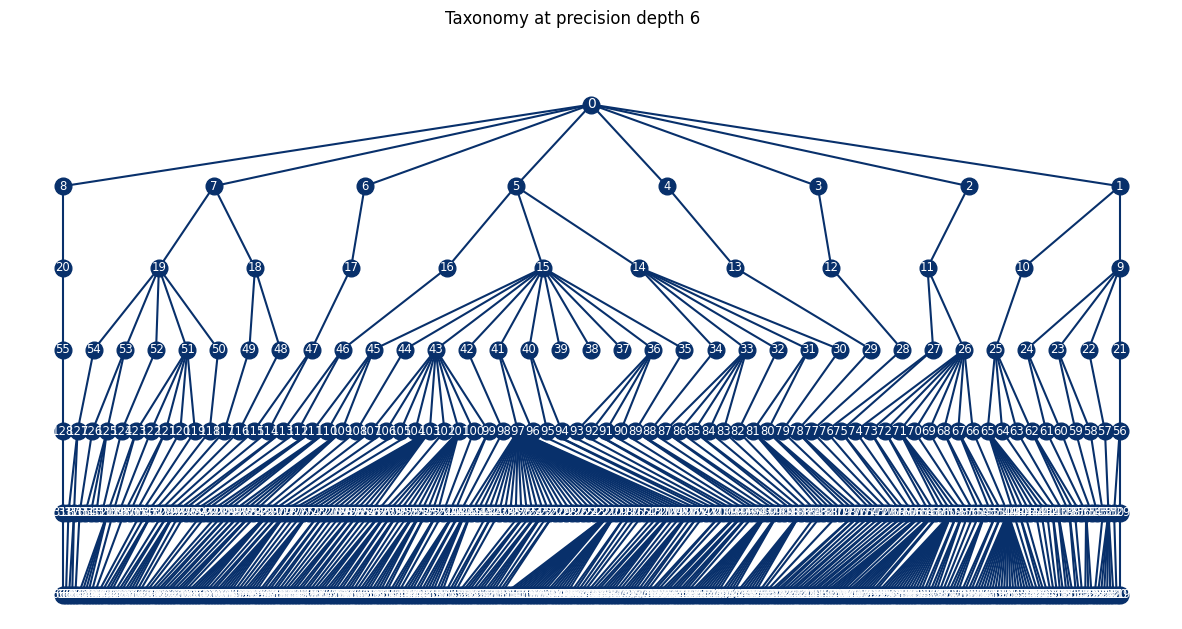

In [13]:
precision_taxonomy=6
global_tree, abundance_trees = microbiota_abundance_trees(precision_max=precision_taxonomy)
global_tree.plot(title=f"Taxonomy at precision depth {precision_taxonomy}", legend=False)

As one can observe, the global taxonomy is very high dimensional, with 784 nodes identified at highest precision. Since we have very few individuals (35), and a lot of features to consider compared to that number (784), we say that we work in a **High Dimensional Low Sample Size framework**.

Quite problematic as well, we observe that after the precision layer of the "genre", there exist nodes that do not necessarily have children in the taxonomy. This hierchical limitation would then introduce a context of **missing data** to we would have to account for when dealing with the whole structure.

However, in that notebook, we will only consider a given precision layer as the entry, which enables us to avoid these missing information for now.

The next tree illustrates a limited taxonomy to the precision depth of "genre" for a better vizualisation.

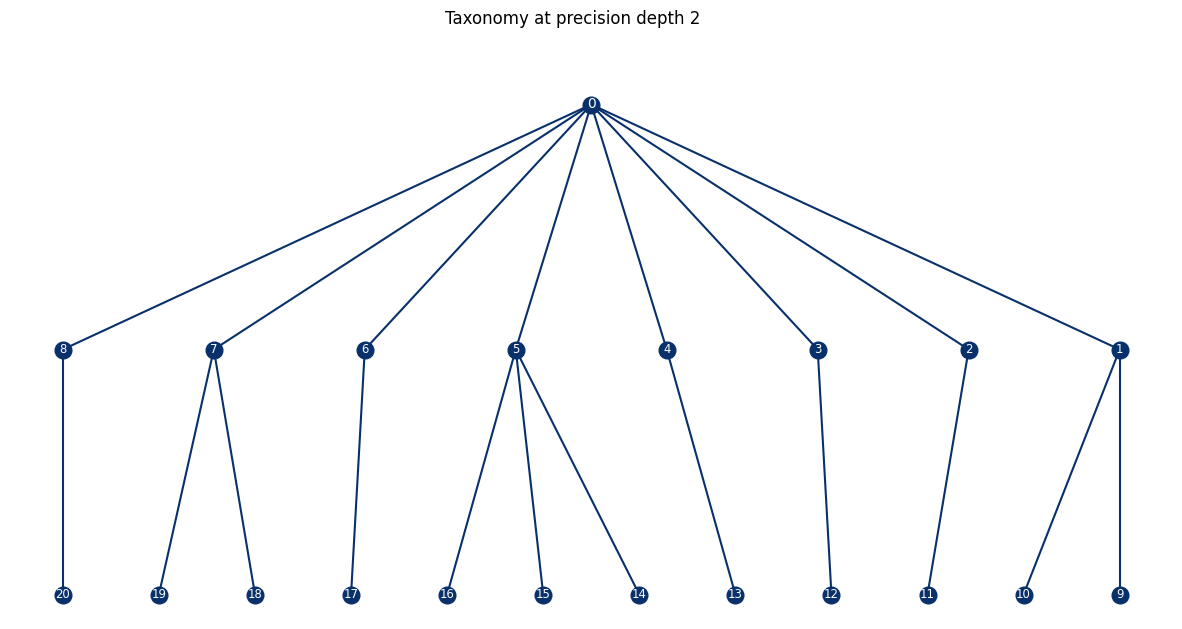

In [14]:
precision_taxonomy=2
global_tree, abundance_trees = microbiota_abundance_trees(precision_max=precision_taxonomy)
global_tree.plot(title=f"Taxonomy at precision depth {precision_taxonomy}", legend=False)

We now look into a specific individual, and annotate the node with their corresponding abundance when limiting the taxonomy view to the node's precision. That produces the following taxa-abundance sample:

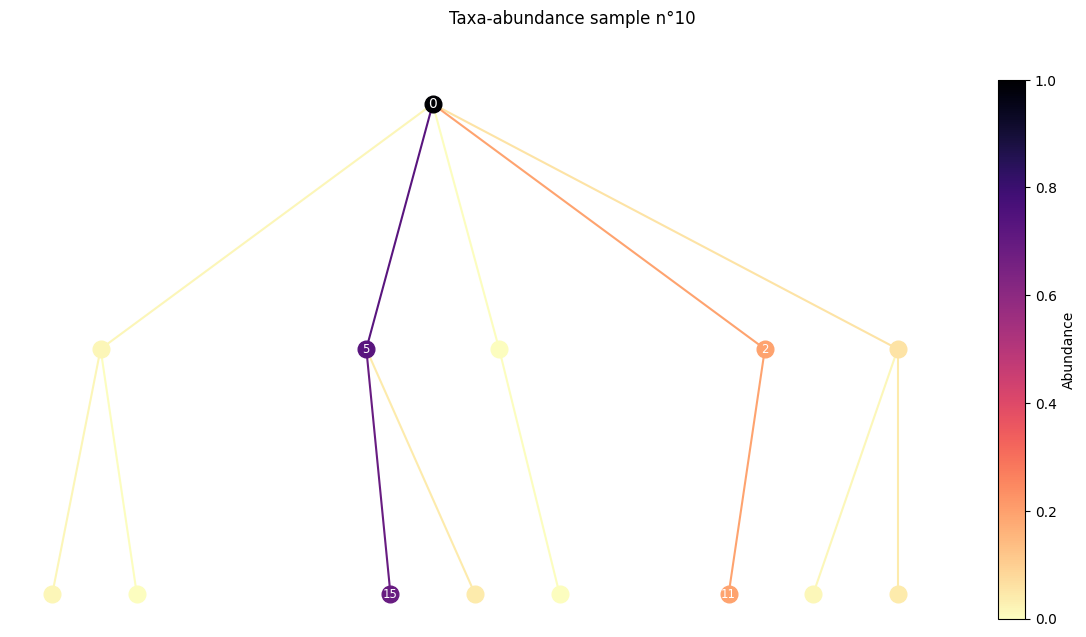

In [15]:
taxaabundance_sample_id = 10
taxaabundance_sample = list(abundance_trees.values())[taxaabundance_sample_id]
taxaabundance_sample.plot(
    title=f"Taxa-abundance sample n°{taxaabundance_sample_id}",
    cmap=plt.cm.get_cmap('magma').reversed(),
    threshold_abundance=10e-2
    )

As we can see, not all nodes from the previous taxonomy is present, as most of the nodes set to 0: we say that the data are **sparse**.

Among the nodes that are not set to 0, we observe that the vast majority of them are very close to 0, and that some nodes account for the vast majority of the layer's abundance.

## <font color=darkred>Logistic regression </font>

In [16]:
# Required packages
np.set_printoptions(precision=2)
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn
from numpy.linalg import norm
from scipy.optimize import check_grad
import seaborn as sns

### <font color=darkred>  Model </font>

$\rightharpoondown$ The objective is to predict the  label $Y\in\{0,1\}$ based on $X\in\mathbb{R}^d$.

$\rightharpoondown$ Logistic regression models the distribution of $Y$ given $X$.

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(w^\top X  + b)\,,
\end{equation*}
where $w \in \mathbb{R}^d$ is a vector of model weights and $b \in \mathbb{R}$ is the intercept, and where $\sigma$ is the sigmoid function.

$$
\sigma: z \mapsto \frac{1}{1 + e^{-z}}\,.
$$

$\rightharpoondown$ **$w$ and $b$ are unknown parameters and are estimated using our dataset**.

$\rightharpoondown$ The sigmoid function is a ``model choice to map $\mathbb{R}$ into $(0,1)$``.

In [17]:
# Sample data according to the logistic regression model
def sigmoid(x):
    expx = np.exp(x)
    z   = expx / (1. + expx)
    return z

def sample_logistic(w0, n_samples=300, corr=0.5):
    n_features = w0.shape[0]
    cov        = toeplitz(corr ** np.arange(0, n_features))
    X          = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p          = sigmoid(X.dot(w0))
    y          = np.random.binomial(1, p, size=n_samples)
    return X, y

Logistic regression models the distribution of $Y$ given $X$.

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(w^\top X + b)\,,
\end{equation*}

**When $w$ and $b$ are known, Bayes classifier assigns an individual $X$ to group 1 if and only if $\mathbb{P}(Y = 1| X) >1/2$ i.e. if and only if  $w^\top X + b>0$.**

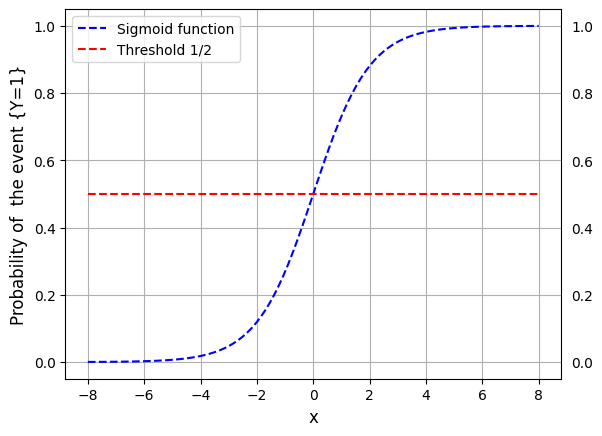

In [18]:
x = np.linspace(-8,8,100)
z = sigmoid(x)
plt.plot(x,z,linestyle = "dashed",color="blue", label= "Sigmoid function")
plt.plot(x,.5*np.ones(np.size(x)),linestyle = "dashed",color="red", label="Threshold 1/2")
plt.ylabel('Probability of  the event {Y=1}', fontsize=12)
plt.xlabel('x', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')
plt.legend();

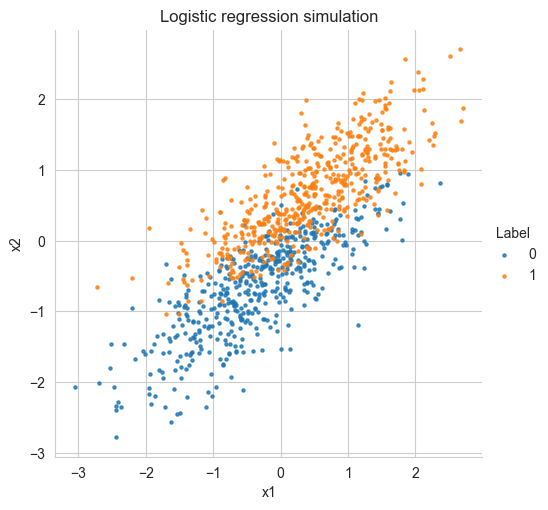

In [19]:
n_samples  = 1000
n_features = 2

w0   = multivariate_normal([-2,6], np.eye(2))

X, y = sample_logistic(w0, n_samples=n_samples, corr = 0.8)

simulated_data          = pd.DataFrame(columns = ["x","y","Label"])
simulated_data["x1"]     = X[:,0]
simulated_data["x2"]     = X[:,1]
simulated_data["Label"] = y

sns.set_style("whitegrid")
sns.lmplot(x = "x1", y = "x2", data = simulated_data, fit_reg = False, hue = "Label", legend = True, scatter_kws={"s": 5})

plt.title("Logistic regression simulation");

The decision function plots the hyperplan $w^\top X + b=0$. Individuals $X$ on one side of the hyperplan are assigned to group 1 and on the other side to group 0.

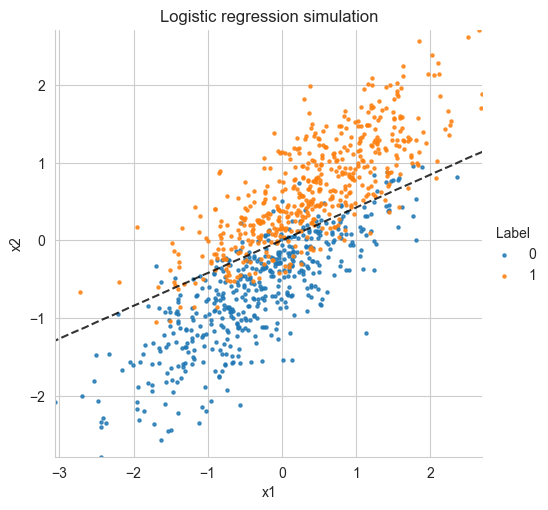

In [20]:

def decision_function(X,w):
    z = sigmoid(X.dot(w))
    return z

xlim  = [np.min(X[:,0]), np.max(X[:,0])]
ylim  = [np.min(X[:,1]), np.max(X[:,1])]
xplot = np.linspace(xlim[0], xlim[1], 30)
yplot = np.linspace(ylim[0], ylim[1], 30)

Yplot, Xplot = np.meshgrid(yplot, xplot)
xy           = np.vstack([Xplot.ravel(), Yplot.ravel()]).T
P            = decision_function(xy,w0).reshape(Xplot.shape)

sns.set_style("whitegrid")
sns.lmplot(x = "x1", y = "x2", data = simulated_data, fit_reg = False, hue = "Label", legend = True, scatter_kws={"s": 5})

plt.title("Logistic regression simulation");

# plot decision boundary and margins
plt.contour(Xplot, Yplot, P, colors = 'k', levels = [0.5], alpha = 0.8, linestyles = ['--']);

### <font color=darkred>  Logistic regression: losses and gradients </font>

If the dataset contains $\{(X_i,Y_i)\}_{1\leq i \leq n}$ independent data, the loglikelihood writes:
$$\ell_n(w) = \sum_{i=1}^n \log \mathbb{P}(Y_i|X_i)$$
ie
$$\ell_n(w) =\sum_{i=1}^n \left\{\mathbb{1}_{Y_i=1}\omega^\top X_i - \log(1 + \exp(X_i^\top w)\right\}\,.$$

The aim of this section is then to detail how to solve the following optimization problem
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}\,,
$$
where $d$ is the number of features.

$$
f: w \mapsto \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \{-Y_iX_i^\top w + \log(1 + \exp(X_i^\top w))\} + \frac{\lambda}{2} \|w\|_2^2\,,
$$
where $n$ is the sample size, and where $Y_i \in \{ 0, 1 \}$ for all $1\leqslant i\leqslant n$.

A basic gradient descent algorithm requires to compute the functions $f$ and $\nabla f$.

In [21]:
class LogisticRegression:
    def __init__(self, X, y, lmbd):
        self.X = X
        self.y = y
        self.lmbd = lmbd
        self.n_samples, self.n_features = X.shape

    def loss(self, w):
        # Computes f(w)
        y, X, n_samples, lmbd = self.y, self.X, self.n_samples, self.lmbd
        res = 0
        for k in range(n_samples):
            res += np.log(1+np.exp(X[k].dot(w))) - y[k]*X[k].dot(w)
        res = res/n_samples
        res += lmbd*0.5*(norm(w)**2)
        return res

    def grad(self, w):
        # Computes the gradient of f at w
        y, X, n_samples, lmbd = self.y, self.X, self.n_samples, self.lmbd
        res = 0
        for k in range(n_samples):
            res += -y[k]*X[k] + np.exp(X[k].dot(w))/(1+np.exp(X[k].dot(w)))*X[k]
        res = res/n_samples
        res += lmbd*w
        return res

In [22]:
# Check numerically the gradient using the function checkgrad from scipy.optimize
# Use the function simu_logreg to simulate data according to the logistic regression model
n_features = 10
w_true     = np.random.randn(n_features)
X, y       = sample_logistic(w_true, n_samples, corr=0.9)
model      = LogisticRegression(X, y, 1e-3)
# check_grad assesses the correctness of a gradient by comparing it to a finite-difference approximation
check_grad(model.loss, model.grad, w_true)

7.102095803163465e-08

### <font color=darkred> Gradient descent </font>

In the case of machine/deep learning applications, the function to be minimized is of the form:
$$
f:w\mapsto  \frac{1}{n}\sum_{i=1}^n \ell(Y_i, w^\top X_i) + \lambda g(w) = \frac{1}{n}\sum_{i=1}^n f_i(w)\,.
$$
The most simple method  is based on full gradients, since at each iteration  it requires to compute
$$
\nabla f(w) = \frac 1n \sum_{i=1}^n \nabla  f_i(w)\,,
$$
which depends on the whole dataset. When processing very large datasets ($n$ is large), this approach has a highly prohibitive computational cost  for a  unique step towards the minimum.
For all $k\geqslant 1$, set
$$
w^{(k)} = w^{(k-1)} - \eta_k \nabla f_{}(w^{(k-1)})\,.
$$
Each iteration has complexity $O(nd)$.

In [23]:
def gd(model, w0, n_iter,step):
    loss_val = np.zeros(n_iter+1)
    w        = w0.copy()
    w_new    = w0.copy()
    for k in range(n_iter + 1):
        w_new[:]    = w-step*model.grad(w)
        w[:]        = w_new
        loss_val[k] = model.loss(w)
    return w, loss_val

In [24]:
step_sgd   = 1e-1
w0         = np.random.randn(n_features)
n_iter_max = 500

w, gd_loss  = gd(model, w0, n_iter = n_iter_max, step = step_sgd)

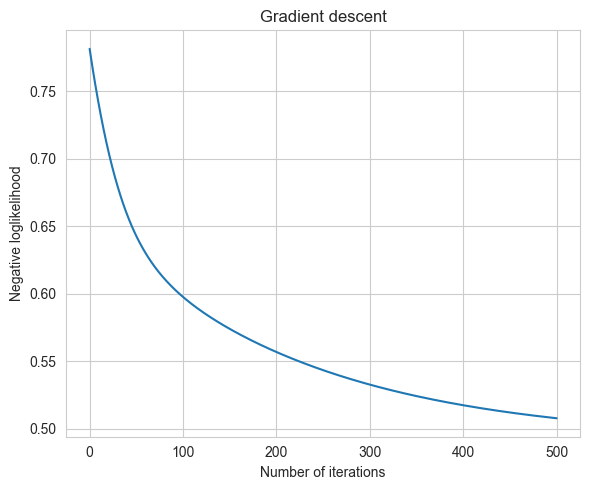

In [25]:
figure = plt.figure(figsize = (6, 5))
plt.plot(gd_loss, '-')
plt.title('Gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout()

### <font color=darkred> ROC curve and AUC</font>

In [26]:
n_test = int(0.2*n_samples)
X_test, y_test = sample_logistic(w0, n_samples = n_test, corr = 0.9)

In [27]:
# predicted class using the estimated model
y_pred = y_test.copy()
for i in range(n_test):
    if X_test[i].dot(w0)>0:
        y_pred[i] = 1.0
    else:
        y_pred[i] = 0.0
print('Mean prediction error with the estimated parameter: %f'%np.mean(np.abs(y_pred-y_test)))

Mean prediction error with the estimated parameter: 0.130000


In [28]:
# predicted probability for each new individual using the estimated model
y_score = np.zeros(n_test)
for i in range(n_test):
    y_score[i] = sigmoid(X_test[i].dot(w0))

The Receiver Operating Characteristic (ROC) curve assesses the diagnostic ability of the classifier  as the classification threshold is modified. Logistic regression models the distribution of $Y$ given $X$ as

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(w^\top X  + b)\,,
\end{equation*}

and the Bayes classifier is defined as

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) > \mathbb{P}(Y = 0| X)$,

which is equivalent to

$f^*(X) = 1$ if and only if $w^\top X  + b>0$,

or also to

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) >1/2$.

Therefore, the theoretical threshold to classify individuals is $1/2$. However, analyzing the sensitivity of the classifier to this threshold may be interesting which is the aim of the ROC curve which displays the True positive rate as a function of the False positive rate when the threshold is changed.

For each value $p^*\in(0,1)$ the ROC curve classifies individuals using

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) > p^*$

and plots the **True positive rate as a function of the False positive rate**.

Depending on the application, an optimal threshold may then be used to obtain satisfying True and False positive rates on the test data set.

In [29]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)
thresholds

array([2.00e+00, 1.00e+00, 9.55e-01, 9.46e-01, 9.27e-01, 9.27e-01,
       8.20e-01, 8.11e-01, 8.08e-01, 7.84e-01, 6.67e-01, 6.40e-01,
       6.19e-01, 6.17e-01, 5.88e-01, 5.79e-01, 5.76e-01, 5.72e-01,
       5.67e-01, 5.61e-01, 5.37e-01, 5.35e-01, 5.30e-01, 5.19e-01,
       5.06e-01, 4.79e-01, 4.78e-01, 4.64e-01, 4.61e-01, 4.58e-01,
       4.44e-01, 4.43e-01, 4.39e-01, 3.93e-01, 3.74e-01, 3.37e-01,
       3.29e-01, 3.09e-01, 2.90e-01, 2.36e-01, 2.26e-01, 1.62e-01,
       1.56e-01, 1.48e-01, 1.46e-01, 8.98e-02, 8.47e-02, 1.41e-02,
       1.29e-02, 1.85e-04])

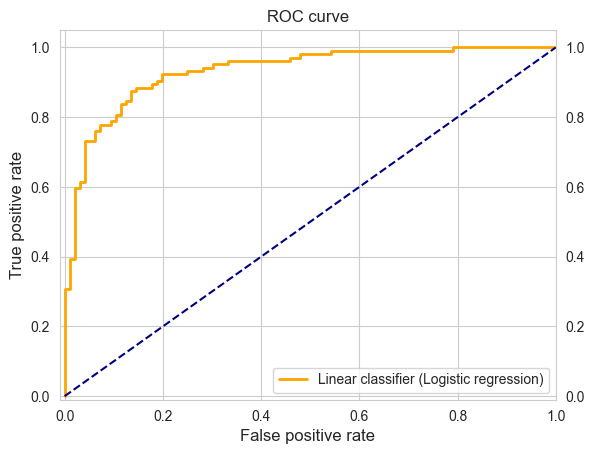

In [30]:
x = np.linspace(-8,8,100)
z = sigmoid(x)
plt.plot(fpr,tpr,lw = 2,color="orange", label = "Linear classifier (Logistic regression)")
plt.title('ROC curve')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.ylabel('True positive rate', fontsize=12)
plt.xlabel('False positive rate', fontsize=12)
plt.tick_params(labelright=True)
plt.legend()
plt.grid('True')

In [31]:
print('The area under the ROC curve (AUC) is: %f'%metrics.auc(fpr, tpr))

The area under the ROC curve (AUC) is: 0.933193


## <font color=darkred> Softmax regression </font>

Logistic regression can be extended to classify data in more than two groups. Softmax regression provides a model for the probability that an input $x$ is associated with each group.  It is assumed that the probability to belong to the class $k\in\{1,\ldots,M\}$ can be expressed by
\begin{equation*}
\mathbb{P}(Y = k| X) = \frac{\exp(w_k^\top X + b_k)}{\sum_{\ell=1}^{M}\exp(w_\ell^\top X + b_\ell)} = p_k(X)\,,
\end{equation*}
where $w_\ell \in \mathbb{R}^d$ and $b_\ell$  are model \textbf{weights} and \textbf{intercepts} for each class.


To estimate these unknown parameters, a maximum likelihood approach is used as in the logistic regression setting. In this case, the loss function is given by the negative log-likelihood (see also the section on gradient based method).

## <font color=darkred> Application to Gut microbiota data </font>


As previously, we fix ourselves a precision layer in the taxonomy and work with the bacteria of that level only.

Here, $p=5$ (genre level) comes in the high precision level regime, with over $190$ bacteria at that layer. The taxonomy is illustrated below.

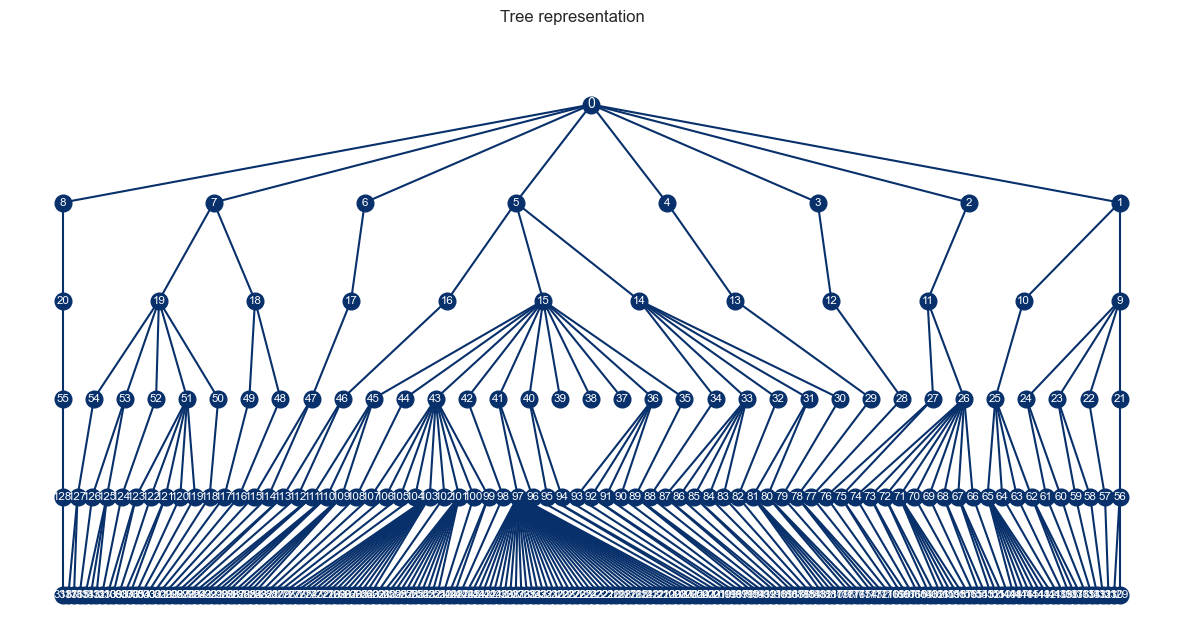

In [32]:
precision_taxonomy = 5

global_tree, abundance_trees = microbiota_abundance_trees(precision_max=precision_taxonomy)
global_tree.plot(legend=False)

We fetch the dataset corresponding to that precision layer.

In [34]:
X, y, bacteria_dic = extract_dataset(abundance_trees, precision=precision_taxonomy, bias=False, return_bacteria_nodes=True)
print(X.shape)
print(y.shape)
print(y.sum(), "/", len(y))

(35, 190)
(35,)
13 / 35


In [35]:
# We compute some statistics on the features to remove those that dont seem relevant
avg_abundance = X.mean(axis=0)
count_presence = X.apply(lambda x: x != 0, axis=0).sum(axis=0)
bacteria_info = pd.DataFrame()
bacteria_info["name"] = [bacteria_dic[x + min(list(bacteria_dic.keys()))].name for x in X.columns]
bacteria_info["avg_abundance"] = avg_abundance
bacteria_info["count_presence"] = count_presence
bacteria_info = bacteria_info.sort_values(by="count_presence")
bacteria_info

# We remove the features that we deem irrelevant from a statistical perspective, because they impact 1 individual or less
X = X.drop(columns=bacteria_info[bacteria_info.count_presence <= 1].index)
print(X.shape)

(35, 163)


In order to assess the quality of our prediction, we have to setup an evaluation procedure of the models.

Previously in that study, we introduce several metrics like the accuracy or the ROC curve. There exists a vast universe of metrics, among which we are going use the following for our problem:
- **Accuracy**: percentage of correctly classified individual in our test set

- **Balanced accuracy**: percentage of correctly classified individual balanced by the proportion of the true label in the dataset. This metric accounts for the unbalanced nature of our dataset (23 label 1 for 14 label 0).

- **F1 score**: another metric for unbalanced dataset, which assesses a balance between precision and recall, which are important to account for in a medical framework (see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

- **Confusion matrix**: matrix explaining the classification outputs, such that  "$C_{ij}$ is equal to the number of observations known to be in $i$ group
 and predicted to be in group $j$". (see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

- **ROC curve**: previously introduced (see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

Training a model and assessing those previous metrics has to be done several times on different subsets of the training set / test set to take into consideration the randomness of the input data. Hence, those metrics will be computed on $30$ folds of the original data (seperated in train/test).

The way we compute the folds is also important, as you should recall we work in an unbalanced framework! Hence, we build our folds in a **stratified** fashion (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html), meaning that we want the folds to have the same distribution in the labels as the original dataset (13/35 label 1 proportion).

### <font color=blue>Cross validation </font>


A trained classifier has to be generalizable: it must be able to work on other data than the training dataset. The empirical error on the training set is a poor estimate of the generalization error (expected error on new data).

A solution is to choose the model that performs best on a **validation set separate from the training set**.

 The simplest approach consists in splitting the data into:
- a learning or training set $D_{n,train}$ used to learn the algorithm,
- a validation or test set $D_{n,test}$ used to evaluate the performance of the trained algorithm.

Then, a standard procedure is:
- Train each model on the train set ;
- Compute the prediction error of each model on the validation set ;
- Pick the model with the smallest prediction error on the validation set.

One of the most popular cross validation strategy is the **$K$-fold validation**.

- Define a random partition $\{I_1,\ldots , I_K\}$  of $\{1,\ldots , n\}$;
- For each $k=1,\ldots, K$,
 - set $I_{train,k} = \{1,\ldots , n \} \setminus I_k \, \, $ and $\, \, I_{test,k} = I_k$ ;
 - train the algorithm with $D_{n,train} = \{ (X_i,Y_i), i \in I_{train,k}\}$ ;
 - compute the test error on $I_{test,k}$.
- Select the algorithm with the best average test score.


![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [41]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
# We can pick various types of cross validation strategies
# - K-Fold is a deterministic one, detailled above
# - Shuffle Split is a random one, somewhat like K-Fold except that it draws randomly samples for the training set and the test set, so you may actually not reach all samples in your folds, but you introduce randomness
# - Stratified Shuffle Split works similarly as the Shuffle one, except that it maintains the labels distributions in the sets, which ensures a regular training, to the cost of selection biases in low sample regimes

n_folds = 30

stratifier = ShuffleSplit(n_splits=n_folds, test_size=0.20)

In [45]:
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score, roc_curve, auc
import math
from scipy import interp

def evaluate(model, X=X, fold_print=False, print_roc=False, submodel_fun=None, return_scores=False, filter_features=None):
    size = n_folds
    mean_accuracy = np.zeros(size)
    mean_balanced_accuracy = np.zeros(size)
    mean_f1 = np.zeros(size)
    mean_auc = np.zeros(size)
    mean_cm = 0
    roc_fpr_list = []
    roc_tpr_list = []

    base_fpr = np.linspace(0, 1, 101)

    if print_roc:
        fig, axs = plt.subplots()
        fig.suptitle(f"ROC curves - {n_folds} folds")

    for i, (train_index, test_index) in enumerate(stratifier.split(X, y)):
        # If we filter out features in the evaluation, that's how we manage it
        if filter_features is not None:
            X_train_fold, y_train_fold = X[filter_features].values[train_index], y.values[train_index]
            X_test_fold, y_test_fold = X[filter_features].values[test_index], y.values[test_index]
        else:
            X_train_fold, y_train_fold = X.values[train_index], y.values[train_index]
            X_test_fold, y_test_fold = X.values[test_index], y.values[test_index]

        # We fit the model on the fold
        model.fit(X_train_fold, y_train_fold)
        # Fetch P(Y = 1 | X) in the model and compare it to the expected label in the ROC
        y_1_pred_proba = model.predict_proba(X_test_fold)[:, 1]
        y_pred = model.predict(X_test_fold)

        fpr, tpr, thresholds = metrics.roc_curve(y_test_fold, y_1_pred_proba)

        tpr_interp = interp(base_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        roc_tpr_list.append(tpr_interp)

        if submodel_fun:
            submodel_fun(model)

        if fold_print:
            print("* Fold", i)
            print("     Accuracy:", model.score(X_test_fold, y_test_fold))
            print("     Balanced Accuracy:", balanced_accuracy_score(y_test_fold, y_pred))
            print("     F1 score:", f1_score(y_test_fold, y_pred))
            print("     AUC:", auc(fpr, tpr))
            print("     Confusion matrix:\n", confusion_matrix(y_test_fold, y_pred))

        mean_accuracy[i] = model.score(X_test_fold, y_test_fold)
        mean_balanced_accuracy[i] = balanced_accuracy_score(y_test_fold, y_pred)
        mean_f1[i] = f1_score(y_test_fold, y_pred)
        mean_auc[i] = auc(fpr, tpr)
        if math.isnan(mean_auc[i]):
            mean_auc[i] = 0
        mean_cm += confusion_matrix(y_test_fold, y_pred)

    if print_roc:
        axs.plot([0, 1], [0, 1], color="navy", linestyle="--")
        axs.set_xlim([-0.01, 1.0])
        axs.set_ylim([-0.01, 1.05])
        axs.set_ylabel('True positive rate', fontsize=12)
        axs.set_xlabel('False positive rate', fontsize=12)
        axs.tick_params(labelright=True)
        axs.grid('True')

        roc_tpr_array = np.array(roc_tpr_list)
        for i in range(len(roc_tpr_array)):
            for j in range(roc_tpr_array.shape[1]):
                if math.isnan(roc_tpr_array[i][j]):
                    roc_tpr_array[i][j] = 0
        mean_tprs = roc_tpr_array.mean(axis=0)
        std_tprs = roc_tpr_array.std(axis=0)
        axs.plot(base_fpr, mean_tprs, 'b', label="avg")
        axs.fill_between(base_fpr, mean_tprs - std_tprs, mean_tprs + std_tprs, color='b', alpha=0.1, label="std")
        axs.legend()

    print("----------------------------------------------------------------")
    print("[Summary]")
    print("     Accuracy:", mean_accuracy.mean(), "±", mean_accuracy.std())
    print("     Balanced Accuracy:", mean_balanced_accuracy.mean(), "±", mean_balanced_accuracy.std())
    print("     F1 score:", mean_f1.mean(), "±", mean_f1.std())
    print("     AUC:", mean_auc.mean(), "±", mean_auc.std())
    print("     (sum) Confusion matrix:\n", mean_cm)
    print("----------------------------------------------------------------")
    if return_scores:
        return mean_accuracy, mean_balanced_accuracy, mean_f1, mean_cm

Now we are ready to evaluate any model from Scikit-Learn classifiers!

### <font color=blue> Logistic regression - evaluation </font>


----------------------------------------------------------------
[Summary]
     Accuracy: 0.6 ± 0.15386185163241442
     Balanced Accuracy: 0.5 ± 0.0
     F1 score: 0.0 ± 0.0
     AUC: 0.5305555555555556 ± 0.209412022247359
     (sum) Confusion matrix:
 [[126   0]
 [ 84   0]]
----------------------------------------------------------------


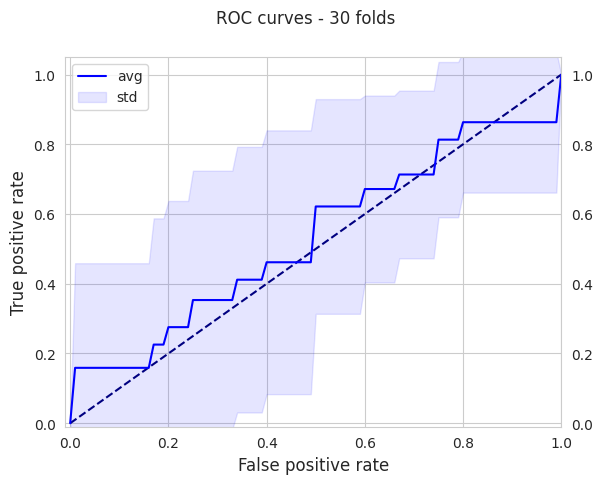

In [38]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(
    penalty='l2',
)

evaluate(logistic_reg, print_roc=True)

As we observe, the performances of the model are really poor: it performs just as well as a dummy random classifier.

Multiple reasons can be explaining why, among which we may give a few:
- The linear approximation is probably not suited for the data, which may highly likely not be linearly seperable. That can be improved considering that we are using **compositional data**, using preprocessing pipelines like log-ratio isoperimetric transformation (see: https://en.wikipedia.org/wiki/Compositional_data).
- The input data is of very high dimension for very few samples, hence the problem is said to be ill-posed, leading to a lot of potential mathematically correct answers to the optimization problem, and yet very few that generalizes. One solution to this might be to perform dimension reduction techniques, like PCA or feature selection through random forest (tackled below).

### <font color=blue> Random Forest classifier - evaluation </font>


For a very nice review of random forests, see https://arxiv.org/abs/1511.05741

----------------------------------------------------------------
[Summary]
     Accuracy: 0.4857142857142857 ± 0.14568627181693672
     Balanced Accuracy: 0.42388888888888887 ± 0.08445723587329879
     F1 score: 0.024444444444444446 ± 0.09186678492708616
     AUC: 0.415 ± 0.25576139053596203
     (sum) Confusion matrix:
 [[100  27]
 [ 81   2]]
----------------------------------------------------------------


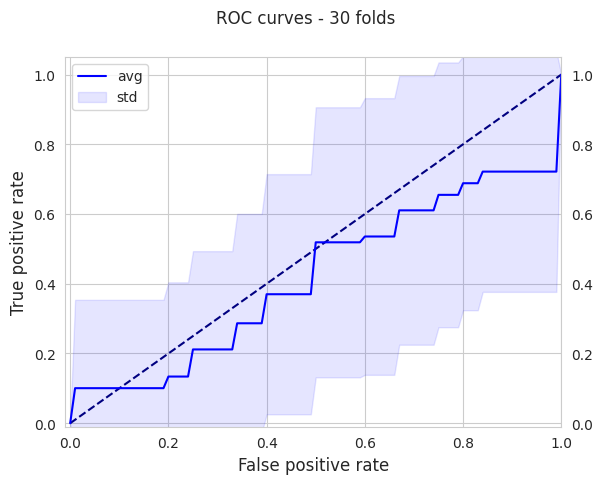

In [39]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=4,
    max_features='sqrt',
    class_weight="balanced"
)

top_features = []

def show_feature_importance(model):
    top_features.append(np.argsort(model.feature_importances_))

evaluate(randomforest, print_roc=True, submodel_fun=show_feature_importance)

As we can see, the performances are very poor using the random forest classifier as such.

We propose two approaches in that case:
- First would be to try to fine tune the model to improve its performances, which we are going to perform through a Random search Cross Validation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
- Then, we can perform data reduction through feature importance by trying to learn what features are the most deterministic in the learning on the trees, and select them aside to try to improve the quality of the predictions.

In a randomized search cross validation we select a few hyperparameters of the model and a grid of values for each hyperparameter.
Then, combinations of values for the hyperparameters are randomly selected and each associated model is trained on the dataset (by default using a 5-fold cross validation where each model is trained 5 times after randomly shuffling training data).

The best hyperparameters are then selected according to the best performance on the test dataset.

In [40]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features is the number of dimension considered to select the best split (the dimension along which a cell is cut)
max_features = ['log2', 'sqrt']
# The maximum depth of the tree corresponds to the maximum number of levels of the tree.
# If not given, splits are performed until all cells contain less than min_samples_split samples.
max_depth = np.arange(3,100,5)
# min_samples_split is the minimum number of samples in a cell to allow a split.
min_samples_split = [2, 3, 4, 5, 6, 7, 8]
# A split is considered in the tree if it leaves at least min_samples_leaf training samples in each
# subcell obtained after the spliting process.
min_samples_leaf = [1, 2, 3, 4]
# if bootstrap is true all the training dataset is used to build each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Setup the estimator, "class_weight" should be on "balanced" mode to account for the unbalance in the labels
randomforest = RandomForestClassifier(class_weight="balanced")
# Random search among  all parameters (the number of possible combination is given. It is not a complete grid search !!!).
# search across n_iter = 10 different combinations with a default 3-fold cross validation.
randomforest_random_grid = RandomizedSearchCV(
    estimator=randomforest,
    param_distributions=random_grid,
    n_iter = 10,
    cv = stratifier,
    verbose=10,
    n_jobs = -1,
    scoring=balanced_accuracy_score
    )

randomforest_random_grid.fit(X,y)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


RandomizedSearchCV(cv=ShuffleSplit(n_splits=30, random_state=None, test_size=0.2, train_size=None),
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 3,  8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73, 78, 83,
       88, 93, 98]),
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring=<function balanced_accuracy_score at 0x7b7f2b848dc0>,
                   verbose=10)

Now, we have at our disposal the best parameters according to the random search, which can then be used to evaluate the quality of random forest on our data set.

Note that other procedures exist to fine tune models in much more advanced fashion, like the package Optuna which uses cutting edge algorithms for hyper parameter tuning: https://optuna.org/

In [41]:
# display the best parameters
randomforest_random_grid.best_params_

{'n_estimators': 200,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 28,
 'bootstrap': True}

----------------------------------------------------------------
[Summary]
     Accuracy: 0.5190476190476191 ± 0.1669385537424581
     Balanced Accuracy: 0.4430952380952381 ± 0.1405331469145562
     F1 score: 0.05793650793650794 ± 0.17514526239030193
     AUC: 0.3894444444444444 ± 0.23969437845249603
     (sum) Confusion matrix:
 [[105  31]
 [ 70   4]]
----------------------------------------------------------------


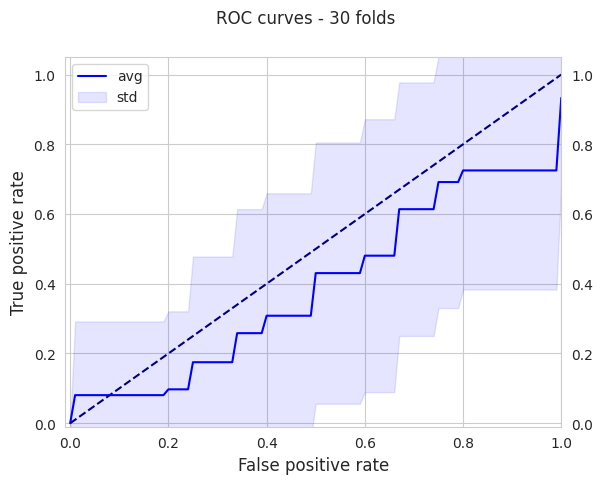

In [42]:
top_features = []

def show_feature_importance(model):
    top_features.append(np.argsort(model.feature_importances_)[::-1])

evaluate(randomforest_random_grid.best_estimator_, print_roc=True, submodel_fun=show_feature_importance)

As we can see, the performances were slightly improved by the fine tuning.

Let's have a look at the second aspect then, what happens when we perform feature selection to reduce the dimensionality of the data ?

The way we perform to select what features to keep is the following:
- We train a random forests model on several data set and output the feature importance of each forest for each experiment.
- Giving those importance over numereous experiments for each feature, we can compute their importance rank (i.e. the ordered index list of the features, from most important ($0$) to least important (highest value))
- Then we compute the average importance rank for each feature, so we obtain an ordered list of the features based on their average importance rank.

We can then take the $d'$ top features according to that criterion, and try to train our model only with these.

In [43]:
# Show the ordered feature importance (columns) over the n_folds experiments (rows)
# Each line is an experiment, and the value in each column is the index to a given feature, which are ordered from the most important to the least one
df_feature_importances = pd.DataFrame(top_features)

In [44]:
# Now that we have an ordered table of importance, we need to fetch the rank for each feature
importance_ranks = {}
for feature in df_feature_importances.columns:
    ranks = []
    for _, experiment in df_feature_importances.iterrows():
        ranks.append(np.where(experiment == feature)[0][0])
    importance_ranks[feature] = ranks

importance_ranks = pd.DataFrame(data=importance_ranks)
importance_ranks.columns = X.columns
importance_ranks

,0,1,2,3,4,6,8,10,11,12,...,175,176,179,180,181,183,184,185,186,188
0,50,135,14,138,7,134,137,27,77,93,...,21,9,11,75,25,133,18,31,63,20
1,101,129,3,133,7,93,135,19,75,87,...,58,14,35,36,62,136,24,95,144,56
2,97,138,8,96,26,106,135,39,43,129,...,18,13,87,60,22,98,21,40,117,67
3,162,134,16,117,35,68,126,31,78,132,...,69,9,5,30,56,102,57,77,141,37
4,108,140,49,138,21,136,135,33,61,131,...,55,58,73,40,22,139,32,63,87,56
5,162,128,25,130,12,116,134,27,47,129,...,34,22,32,66,45,127,19,38,142,35
6,110,140,20,96,7,136,105,41,43,102,...,36,30,37,24,9,137,21,92,85,3
7,114,138,50,136,44,66,107,45,83,131,...,53,19,88,63,68,137,74,89,150,49
8,162,117,7,133,18,126,129,26,20,89,...,21,25,6,37,34,131,68,94,145,44
9,103,128,1,135,16,137,136,42,69,83,...,39,59,22,43,40,129,37,76,90,10


Now, for visualisation purposes, we compute the frequency profile of each feature, i.e, the position (x-axis) frequency (y-axis) of each bacteria in the feature importance.

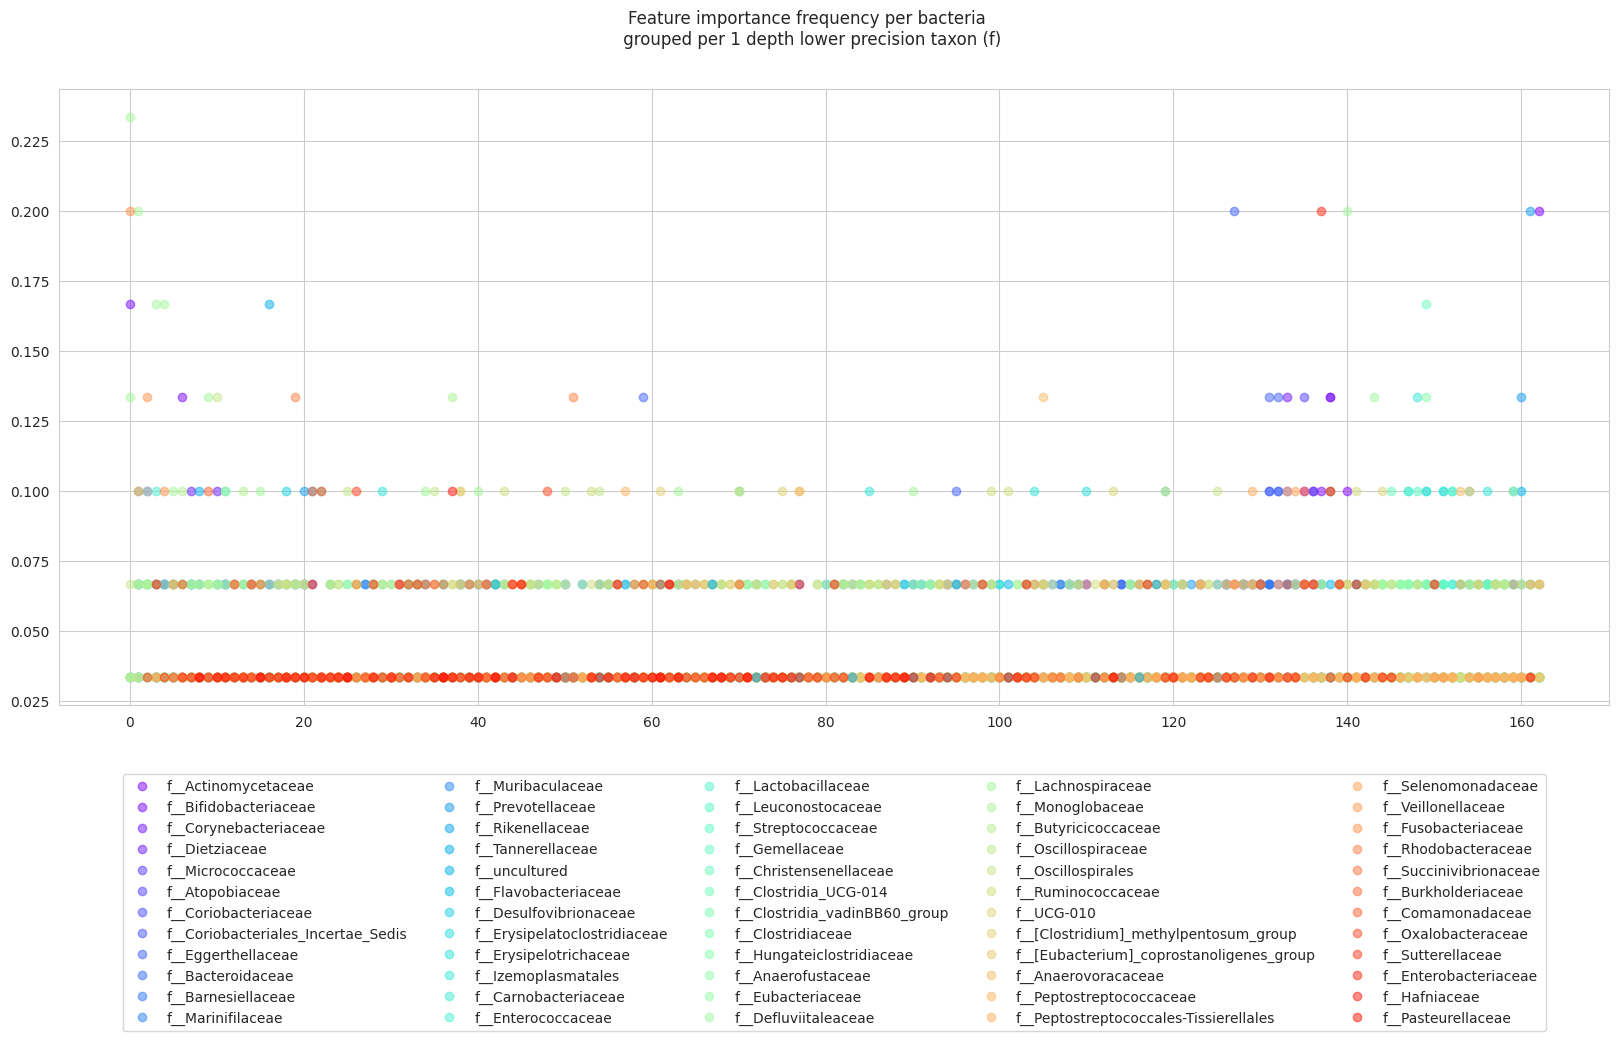

In [45]:
features_importance_profile = {}
features_frequencies = {}

for feature in importance_ranks.columns:

    importances = importance_ranks[feature].values
    unique, counts = np.unique(importances, return_counts=True)
    freq = np.zeros(len(importance_ranks.columns))
    for index, importance in enumerate(unique):
        freq[importance] = counts[index]

    features_importance_profile[feature] = freq

parent_taxon_mapping = {}
n_parents = 0
for index in bacteria_dic:
    if bacteria_dic[index].parent.name not in parent_taxon_mapping:
        parent_taxon_mapping[bacteria_dic[index].parent.name] = n_parents
        n_parents += 1

fig, axs = plt.subplots(figsize=(20, 8))

plotted_labels = []
for i, (feature, freq) in enumerate(features_importance_profile.items()):
    indexes = np.where(freq != 0)[0]
    features_frequencies[feature] = freq/n_folds

    parent_group = parent_taxon_mapping[bacteria_dic[feature+min(list(bacteria_dic.keys()))].parent.name]
    label = None
    if parent_group not in plotted_labels:
        label = f"{bacteria_dic[feature+min(list(bacteria_dic.keys()))].parent.name}"
        plotted_labels.append(parent_group)
    axs.plot(indexes, features_frequencies[feature][indexes],
             label=label,
             marker="o", linestyle="",
             color=plt.cm.get_cmap('rainbow')(parent_group/n_parents - 10e-6),
             alpha=0.5)

    fig.suptitle("Feature importance frequency per bacteria \n grouped per 1 depth lower precision taxon (f)")

axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)

Now, we select the top $8$ features for examples. To do so, we compute the average position in the leaderboard for all features, and we select the top $8$ in the sorted average position.

In [46]:
best_features_sorted = importance_ranks.mean(axis=0).sort_values()
df_best_features_order = pd.DataFrame()
df_best_features_order['bacteria'] = [bacteria_dic[x+min(list(bacteria_dic.keys()))].name for x in best_features_sorted.index]
df_best_features_order['feature'] = best_features_sorted.index
df_best_features_order['avg_importance_position'] = best_features_sorted.values
df_best_features_order

,bacteria,feature,avg_importance_position
0,g__Anaerostipes,76,5.800000
1,g__Bifidobacterium,2,10.000000
2,g__Blautia,77,10.100000
3,g__Fusobacterium,170,10.366667
4,g__Butyricicoccus,119,14.700000
...,...,...,...
158,g__Defluviitaleaceae_UCG-011,74,146.500000
159,g__Ruminiclostridium,70,147.000000
160,g__uncultured,32,148.133333
161,g__Izemoplasmatales,54,148.366667


In [47]:
selected_features = df_best_features_order.head(8)['feature'].values
selected_features

array([ 76,   2,  77, 170, 119,  81,   4,  22])

We can then train a new randomforest model with these selected features only in $X$.

In [48]:
randomforest_random_grid.fit(X[selected_features],y)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


RandomizedSearchCV(cv=ShuffleSplit(n_splits=30, random_state=None, test_size=0.2, train_size=None),
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 3,  8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73, 78, 83,
       88, 93, 98]),
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring=<function balanced_accuracy_score at 0x7b7f2b848dc0>,
                   verbose=10)

----------------------------------------------------------------
[Summary]
     Accuracy: 0.7380952380952384 ± 0.16936589755979753
     Balanced Accuracy: 0.7282936507936507 ± 0.19678411385413336
     F1 score: 0.5806349206349206 ± 0.2880852243657394
     AUC: 0.7944444444444443 ± 0.2379827776733766
     (sum) Confusion matrix:
 [[109  25]
 [ 30  46]]
----------------------------------------------------------------


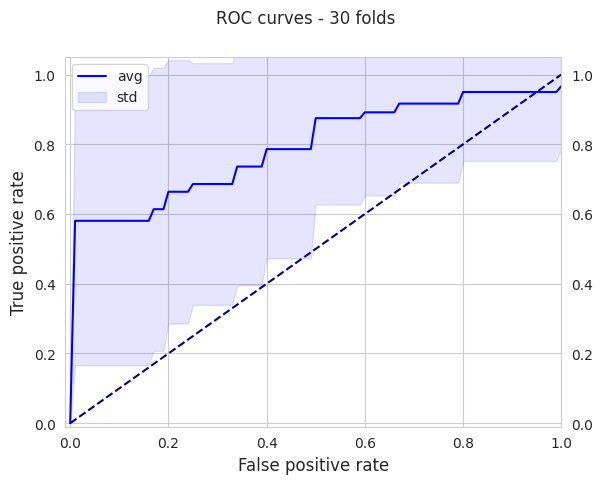

In [49]:
evaluate(randomforest_random_grid.best_estimator_, print_roc=True, filter_features=selected_features)

As we can see, feature selection, combined with fine tuning, significantly improved the results.

Note that feature selection also provides an interpretation of the model decision.

### <font color=blue> (Exercise) XGBoost classifier - evaluation </font>


For a simple introduction to XGBoost classifier, see https://xgboost.readthedocs.io/en/stable/tutorials/model.html

Implement the cross-validation for the XGBoost classifier from Sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

Optimize the parameters of the model using the RandomSearchCV, as we performed it above.

If you are motivated, you can even look in methods for variables selection like we performed using the random forest importance feature: https://scikit-learn.org/stable/modules/feature_selection.html

----------------------------------------------------------------
[Summary]
     Accuracy: 0.5047619047619047 ± 0.17195685795493132
     Balanced Accuracy: 0.4736111111111111 ± 0.1803071944386555
     F1 score: 0.2808994708994709 ± 0.23258833784400848
     AUC: 0.42083333333333334 ± 0.23722693854275986
     (sum) Confusion matrix:
 [[82 51]
 [53 24]]
----------------------------------------------------------------


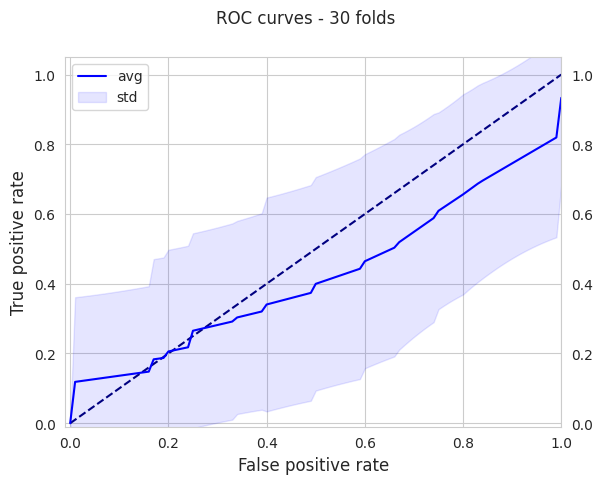

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the model
xgboost = ...

# Evaluate the model (cross validation)
evaluate(xgboost, print_roc=True)

## <font color=darkred> Feature engineering on microbiota data </font>

Very often in machine learning, the raw observations are not well suited for performance and/or speed in the learning procedure, leading to poor quality results.
In a nutshell, feature engineering consists in converting the raw data into efficient features using statistical transformations or ML pipeline (https://en.wikipedia.org/wiki/Feature_engineering).

Finding what to do with the raw data can be quite complicated though, and it may often require some domain-specific knowledge.
Generally, a first lead to build specific features consists in taking advantage of the data inherent structure.

In the context of the microbiota data we are studying, the data are said to be compositional (i.e. proportions of a whole - abundance). 
Several transformations are classificaly introduced for compositional data: https://en.wikipedia.org/wiki/Compositional_data#Aitchison_geometry

We decide to focus on the isometric logratio transform, which is explained in details here: https://en.wikipedia.org/wiki/Compositional_data#Isometric_logratio_transform


We start by importing the data as previously, clean them of the features that are presents for 1 or less individual.

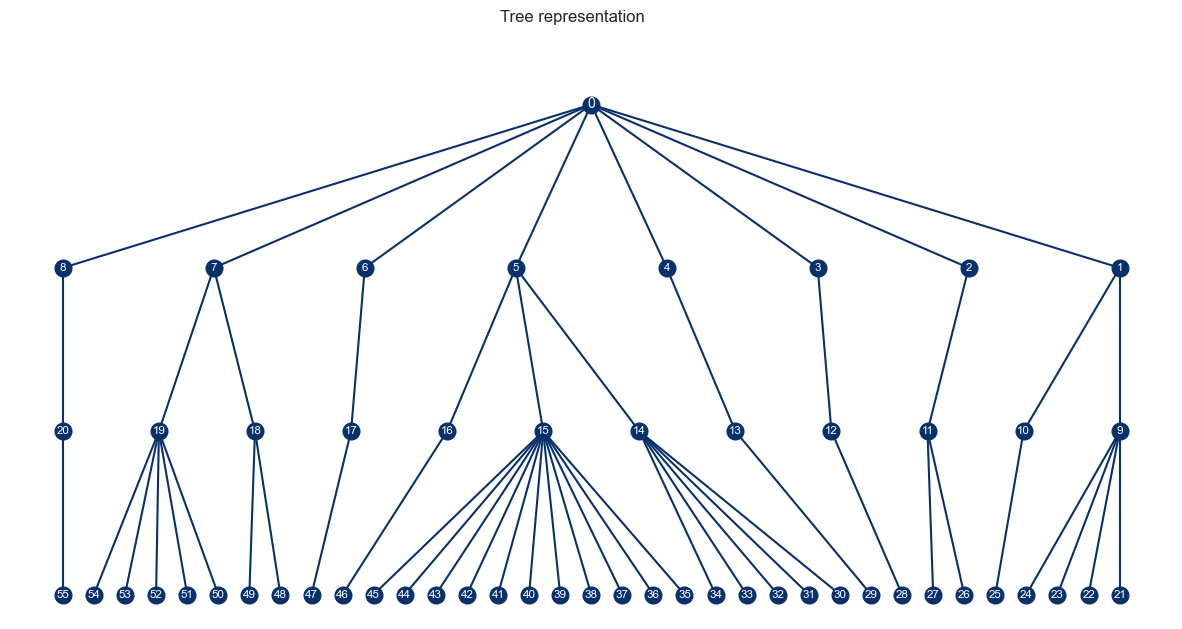

In [33]:
# Decide the precision we are going to work at
precision_taxonomy = 3

global_tree, abundance_trees = microbiota_abundance_trees(precision_max=precision_taxonomy)
global_tree.plot(legend=False)

In [37]:
X, y, bacteria_dic = extract_dataset(abundance_trees, precision=precision_taxonomy, bias=False, return_bacteria_nodes=True)

# We compute some statistics on the features to remove those that dont seem relevant
avg_abundance = X.mean(axis=0)
count_presence = X.apply(lambda x: x != 0, axis=0).sum(axis=0)
bacteria_info = pd.DataFrame()
bacteria_info["name"] = [bacteria_dic[x + min(list(bacteria_dic.keys()))].name for x in X.columns]
bacteria_info["avg_abundance"] = avg_abundance
bacteria_info["count_presence"] = count_presence
bacteria_info = bacteria_info.sort_values(by="count_presence")
bacteria_info

# We remove the features that we deem irrelevant from a statistical perspective, because they impact 1 individual or less
X = X.drop(columns=bacteria_info[bacteria_info.count_presence <= 1].index)
print(X.shape)

(35, 30)


We install a package to perform transformations for compositional data

In [35]:
!pip install composition_stats

We perform the isometric logratio transformation on the data

In [39]:
from composition_stats import multiplicative_replacement
from composition_stats import ilr

X_raw = multiplicative_replacement(X.values, 1e-10)
X_raw = ilr(X_raw)
X_ilr = pd.DataFrame(index=X.index, data=X_raw)
X_ilr.head(5)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
FRA022001CA,-1.378317e+01,-4.457775e+00,1.001650e+01,-7.172724,-10.948521,11.366597,9.843762,8.681382,7.764864,-8.967365,...,-12.450020,-7.079944,-10.145906,9.234227,-6.109032,9.108811,8.764957,-9.288264,8.783451,8.485620
FRA022002BB,-1.005757e+01,-6.632710e+00,8.503997e+00,-7.825994,-12.183943,10.497963,9.091503,8.017952,7.171474,-11.834595,...,-13.174646,-9.148070,7.248163,6.939588,-9.640480,7.047478,6.781439,-12.277168,-10.204631,7.333926
FRA022003GA,1.037284e+01,5.988763e+00,4.234695e+00,-14.868391,-13.388403,8.736412,-8.573133,-7.972261,9.651448,-11.575002,...,-10.428596,7.066688,6.752454,6.464983,-7.711530,6.514669,6.268743,-11.490254,-14.764339,6.968455
FRA022004MC,6.059138e-16,-4.579887e-15,1.082217e-14,-16.093149,-16.673033,-9.447443,-9.917781,-7.924451,9.827979,-8.011798,...,-11.380029,-7.081613,-4.290347,-6.687499,-4.139697,-7.072986,11.685038,-6.916853,-6.582445,11.748328
FRA022005KF,-1.244689e+01,7.186214e+00,-8.278222e+00,-7.483542,-10.855081,11.028799,9.551220,-8.179129,9.390322,-10.782287,...,-11.798742,-9.329594,-8.034290,-11.283768,-5.992206,10.049378,9.670019,-7.515273,9.592786,9.267512


We compare the performances of an XGBoost model when using the raw features and when using the isometric logratio transform.

----------------------------------------------------------------
[Summary]
     Accuracy: 0.5771428571428571 ± 0.17013799921096462
     Balanced Accuracy: 0.5563809523809523 ± 0.19672722750248967
     F1 score: 0.3660833333333333 ± 0.2645455069644957
     AUC: 0.5404583333333334 ± 0.26843993418247014
     (sum) Confusion matrix:
 [[608 312]
 [280 200]]
----------------------------------------------------------------


Text(0.5, 1.0, 'Without isometric logratio transform')

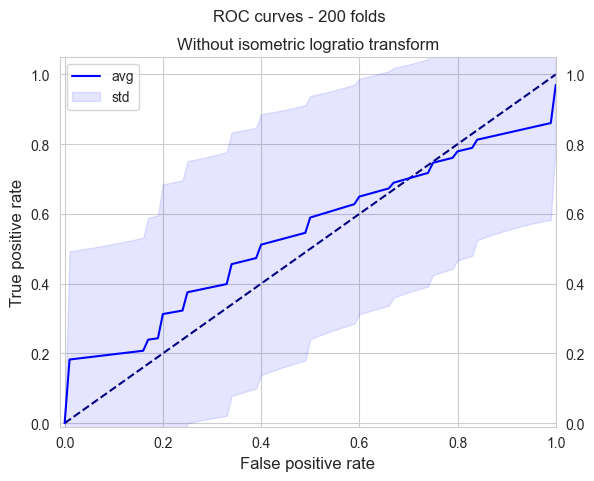

In [63]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import ShuffleSplit
n_folds = 200

stratifier = ShuffleSplit(n_splits=n_folds, test_size=0.20)

xgboost = GradientBoostingClassifier(
    learning_rate=1.2,
    n_estimators=10,
    max_depth=1,
    random_state=0
)

evaluate(xgboost, X=X, print_roc=True)
plt.title("Without isometric logratio transform")

----------------------------------------------------------------
[Summary]
     Accuracy: 0.6264285714285713 ± 0.19149119444773538
     Balanced Accuracy: 0.5988571428571429 ± 0.2017170075471745
     F1 score: 0.43262301587301594 ± 0.29548394352520124
     AUC: 0.6265833333333333 ± 0.24975736837089624
     (sum) Confusion matrix:
 [[643 243]
 [294 241]]
----------------------------------------------------------------


Text(0.5, 1.0, 'With isometric logratio transform')

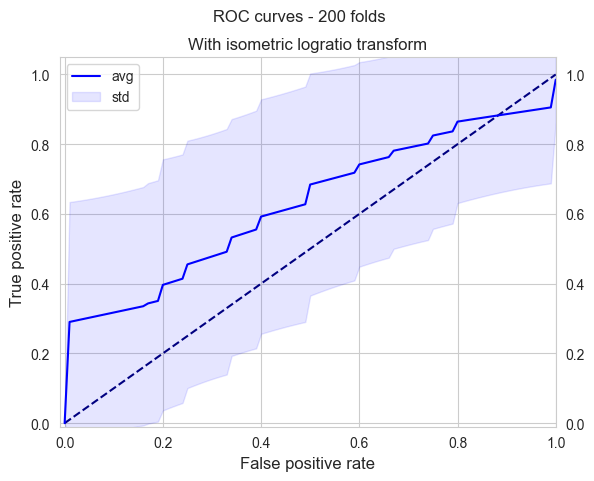

In [64]:
from sklearn.ensemble import GradientBoostingClassifier

xgboost = GradientBoostingClassifier(
    learning_rate=1.2,
    n_estimators=10,
    max_depth=1,
    random_state=0
)

evaluate(xgboost, X=X_ilr, print_roc=True)
plt.title("With isometric logratio transform")

## <font color=darkred> Dimensionality reduction with Poisson Log-Normal model </font>

In this section, we look into another approach to dimensionality reduction.
Previously, we performed variable selection, which consists in pruning variables based on some importance criterion (in RandomForest case, the impurity criterion).

Another well known approach consists in smartly combining features, so that we obtain fewer of them. One common and simple approach consists in finding linear combinations of features so that it explains the most the variance of the data: it's the Principal Components Analysis (PCA: https://en.wikipedia.org/wiki/Principal_component_analysis).

For count data specifically, a PCA variant was introduced by Chiquet et al. (2022) (https://hal.science/hal-04033421/document).
Thankfully, a library in Python has been developped to perform it: https://pypi.org/project/pyPLNmodels/

In [51]:
# We start by installing the library
!pip install pyPLNmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 2.6 MB/s eta 0:00:00


In [52]:
# We import the package
import pyPLNmodels
from pyPLNmodels.models import PlnPCA, Pln

(35, 313)
(35,)
13 / 35


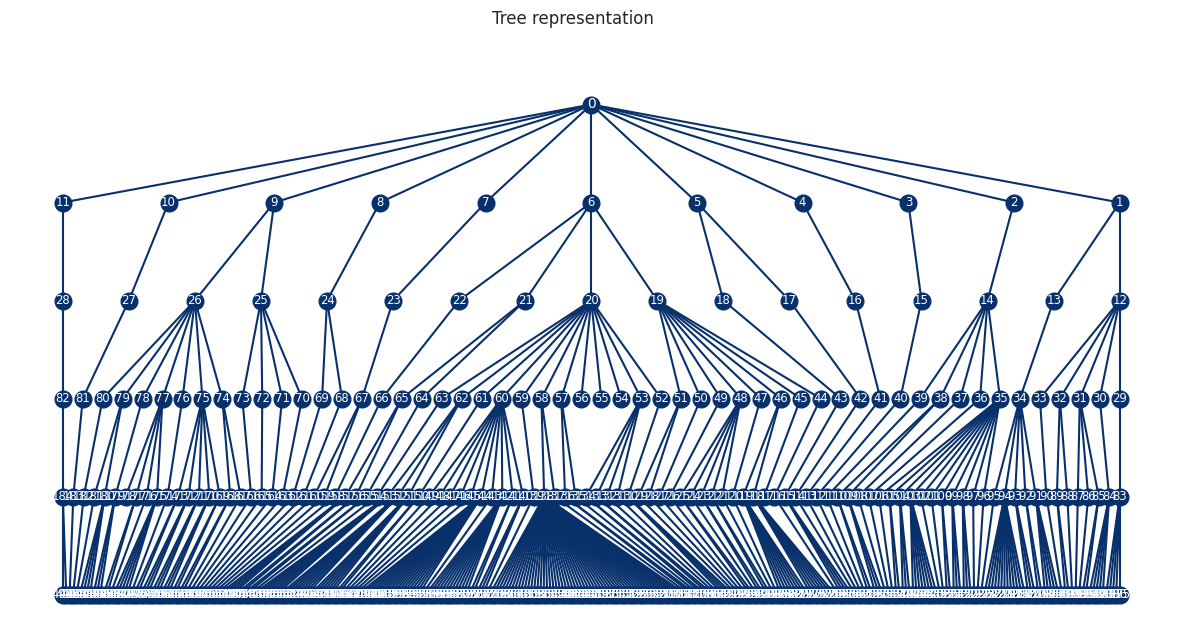

In [53]:
# Pulling the dataset as count data
precision_taxonomy = 5

global_tree, abundance_trees = microbiota_abundance_trees(precision_max=precision_taxonomy, normalize=False)
global_tree.plot(legend=False)

X, y, bacteria_dic = extract_dataset(abundance_trees, precision=5, bias=False, return_bacteria_nodes=True)
print(X.shape)
print(y.shape)
print(y.sum(), "/", len(y))

In [54]:
X

,0,1,2,3,4,5,6,7,8,9,...,303,304,305,306,307,308,309,310,311,312
FRA022001CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1018.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA022002BB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA022003GA,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA022004MC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA022005KF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA022006TS,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1188.0,0.0,0.0,...,137.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA022007LP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,0.0,0.0,...,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA022008DM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4129.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA022010KI,4.0,0.0,0.0,0.0,0.0,0.0,0.0,8174.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA022011RB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,503.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Studying the frequency of appearing for each feature
avg_abundance = X.mean(axis=0)
count_presence = X.apply(lambda x: x != 0, axis=0).sum(axis=0)
bacteria_info = pd.DataFrame()
bacteria_info["name"] = [bacteria_dic[x + min(list(bacteria_dic.keys()))].name for x in X.columns]
bacteria_info["avg_abundance"] = avg_abundance
bacteria_info["count_presence"] = count_presence
bacteria_info = bacteria_info.sort_values(by="count_presence")
bacteria_info

,name,avg_abundance,count_presence
312,g__Fretibacterium,0.000000,0
147,g__Johnsonella,0.000000,0
148,g__Lachnoanaerobaculum,0.000000,0
282,g__Brachymonas,0.000000,0
279,g__Lautropia,0.000000,0
...,...,...,...
109,g__Streptococcus,1069.428571,34
65,g__Parabacteroides,656.485714,34
149,g__Lachnoclostridium,776.028571,34
42,g__Bacteroides,5679.371429,35


In [56]:
# Dropping the features present for 1 individual or less
X = X.drop(columns=bacteria_info[bacteria_info.count_presence <= 1].index)
X

,0,3,7,10,11,12,14,16,18,19,...,287,289,290,291,294,295,296,298,303,310
FRA022001CA,0.0,0.0,1018.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,40.0,157.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA022002BB,0.0,0.0,8.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,...,0.0,118.0,1074.0,0.0,0.0,209.0,0.0,0.0,0.0,0.0
FRA022003GA,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,31.0,0.0,184.0,0.0,8145.0,0.0,0.0,0.0,0.0
FRA022004MC,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,61.0,4.0,427.0,0.0,399.0,0.0,0.0,0.0,0.0
FRA022005KF,0.0,0.0,141.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,...,0.0,25.0,29.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA022006TS,10.0,0.0,1188.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,20.0,29.0,65.0,0.0,183.0,0.0,0.0,137.0,0.0
FRA022007LP,0.0,0.0,66.0,19.0,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,7.0,224.0,0.0,0.0,35.0,0.0,972.0,17.0,0.0
FRA022008DM,0.0,0.0,4129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,19.0,0.0,653.0,0.0,7518.0,54.0,0.0,0.0,0.0
FRA022010KI,4.0,0.0,8174.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,18.0,0.0,149.0,0.0,10.0,0.0,0.0,0.0,0.0
FRA022011RB,0.0,0.0,503.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,6.0,66.0,277.0,0.0,9.0,0.0,77.0,0.0,0.0


In [57]:
# Doing PCA with n components
n_components = 10
pln = PlnPCA(X.values, add_const=True, rank=n_components)
pln.fit()

# Using PlnPCACollection, We can test multiple n_components at a time by putting it as a list, best one is figured out from BIC or AIC
# n_components = [8, 15, 20]
# pca_col = PlnPCAcollection(X.values, add_const=True, ranks=n_components)
# pca_col.fit()
# pca_col.show()

Setting the offsets as the log of the sum of endog
----------------------------------------------------------------------
Fitting a PlnPCAcollection model with 10 components
Initialization ...
Initialization finished
Maximum number of iterations reached :  50000 last criterion =  0.00315188


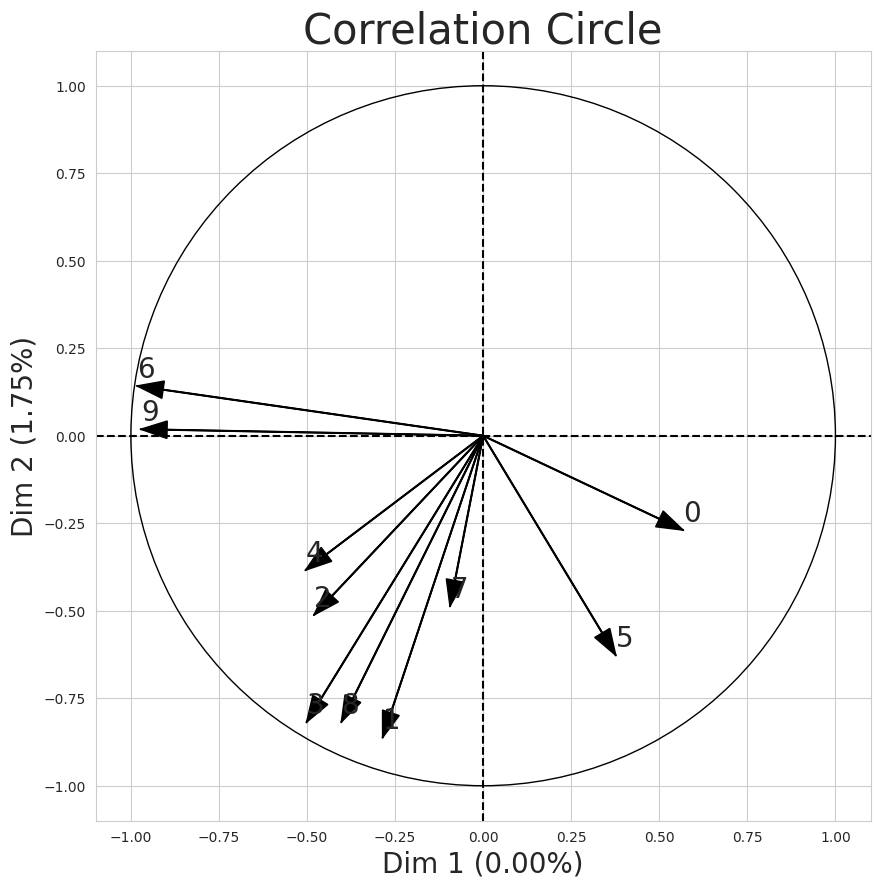

In [58]:
pln.plot_pca_correlation_graph([f"{x}" for x in range(n_components)], indices_of_variables = [x for x in range(n_components)])